🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/1zwncJBdSp0ojlqCjOIoUkw （提取码：dyhb）

🚀我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2.4.1
- 显卡（GPU）：NVIDIA GeForce RTX 3080

**如果你是一名深度学习小白可以先看看我这个专门为你写的专栏：[《小白入门深度学习》](https://blog.csdn.net/qq_38251616/category_11188161.html)**

# 一、设置GPU

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpu0],"GPU")
    
import matplotlib.pyplot as plt
import os,PIL,pathlib
import numpy as np
import pandas as pd
import warnings
from tensorflow import keras

warnings.filterwarnings("ignore")#忽略警告信息
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 二、导入数据

## 1. 导入数据

In [2]:
import pathlib

data_dir = "./28-data/"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*')))
print("图片总数为：",image_count)

图片总数为： 12000


In [3]:
batch_size = 16
img_height = 224
img_width  = 224

In [4]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789

通过该方法导入数据时，会同时打乱数据
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 12000 files belonging to 15 classes.
Using 9600 files for training.


In [5]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789

通过该方法导入数据时，会同时打乱数据
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 12000 files belonging to 15 classes.
Using 2400 files for validation.


In [6]:
class_names = train_ds.class_names
print("数据类别有：",class_names)
print("识别的水果一共%d类"%len(class_names))

数据类别有： ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes', 'muskmelon']
识别的水果一共15类


## 2. 检查数据

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16,)


## 3. 配置数据集

- **shuffle() ：** 打乱数据。
- **prefetch() ：** 预取数据，加速运行，其详细介绍可以参考我前两篇文章，里面都有讲解。
- **cache() ：** 将数据集缓存到内存当中，加速运行

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

def train_preprocessing(image,label):
    return (image/255.0,label)

train_ds = (
    train_ds.cache()
#     .shuffle(2000)
    .map(train_preprocessing)    # 这里可以设置预处理函数
#     .batch(batch_size)           # 在image_dataset_from_directory处已经设置了batch_size
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds.cache()
#     .shuffle(2000)
    .map(train_preprocessing)    # 这里可以设置预处理函数
#     .batch(batch_size)         # 在image_dataset_from_directory处已经设置了batch_size
    .prefetch(buffer_size=AUTOTUNE)
)

## 4. 数据可视化

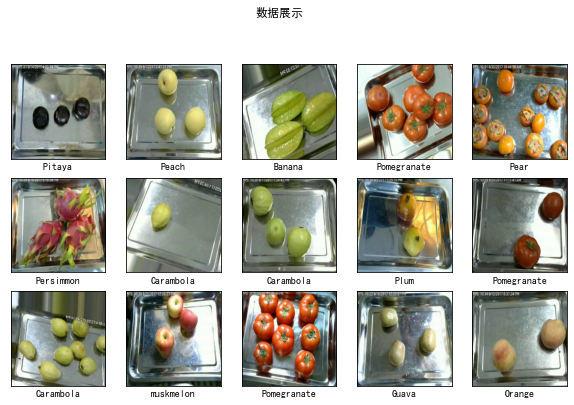

In [9]:
plt.figure(figsize=(10, 8))  # 图形的宽为10高为5
plt.suptitle("数据展示")

for images, labels in train_ds.take(1):
    for i in range(15):
        plt.subplot(4, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # 显示图片
        plt.imshow(images[i])
        # 显示标签
        plt.xlabel(class_names[labels[i]-1])

plt.show()

# 三、构建模型

在这次训练的过程中我发现一个有趣的现象：当我使用复杂的网络时，训练效果不是很理想；当采用相对简单的网络时，效果反而还不错。

In [10]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization,Activation

# 加载预训练模型
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

for layer in base_model.layers:
    layer.trainable = True
    
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(len(class_names), activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

# 四、编译

In [11]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# 五、训练模型

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

NO_EPOCHS = 10
PATIENCE  = 5
VERBOSE   = 1

# 设置动态学习率
# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** (x+NO_EPOCHS))

# 设置早停
earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)

# 
checkpointer = ModelCheckpoint('best_model.h5',
                                monitor='val_accuracy',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)

In [13]:
train_model  = model.fit(train_ds,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=val_ds,
                  callbacks=[ earlystopper, checkpointer])

Epoch 1/10
600/600 [==============================] - 69s 102ms/step - loss: 1.1508 - accuracy: 0.9054 - val_loss: 2.5911 - val_accuracy: 0.1483

Epoch 00001: val_accuracy improved from -inf to 0.14833, saving model to best_model.h5
Epoch 2/10
600/600 [==============================] - 50s 84ms/step - loss: 0.7271 - accuracy: 0.9951 - val_loss: 0.5249 - val_accuracy: 0.9967

Epoch 00002: val_accuracy improved from 0.14833 to 0.99667, saving model to best_model.h5
Epoch 3/10
600/600 [==============================] - 50s 83ms/step - loss: 0.5007 - accuracy: 0.9941 - val_loss: 0.3376 - val_accuracy: 0.9954

Epoch 00003: val_accuracy did not improve from 0.99667
Epoch 4/10
600/600 [==============================] - 51s 84ms/step - loss: 0.3329 - accuracy: 0.9980 - val_loss: 0.4379 - val_accuracy: 0.9538

Epoch 00004: val_accuracy did not improve from 0.99667
Epoch 5/10
600/600 [==============================] - 51s 85ms/step - loss: 0.2586 - accuracy: 0.9910 - val_loss: 0.1588 - val_accur

# 六、评估模型

## 1. Accuracy与Loss图

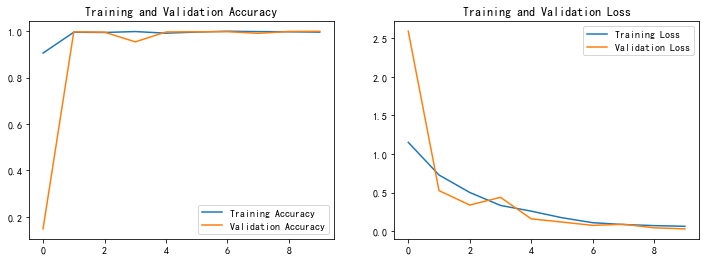

In [14]:
acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 2. 混淆矩阵

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# 定义一个绘制混淆矩阵图的函数
def plot_cm(labels, predictions):
    
    # 生成混淆矩阵
    conf_numpy = confusion_matrix(labels, predictions)
    # 将矩阵转化为 DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)  
    
    plt.figure(figsize=(8,7))
    
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    
    plt.title('混淆矩阵',fontsize=15)
    plt.ylabel('真实值',fontsize=14)
    plt.xlabel('预测值',fontsize=14)

In [16]:
val_pre   = []
val_label = []

for images, labels in val_ds:#这里可以取部分验证数据（.take(1)）生成混淆矩阵
    for image, label in zip(images, labels):
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(image, 0) 
        # 使用模型预测图片中的人物
        prediction = model.predict(img_array)

        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

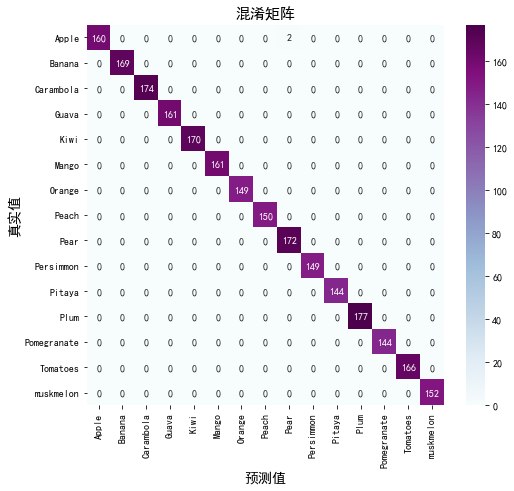

In [17]:
plot_cm(val_label, val_pre)

## 3. 各项指标评估

In [18]:
from sklearn import metrics

def test_accuracy_report(model):
    print(metrics.classification_report(val_label, val_pre, target_names=class_names)) 
    score = model.evaluate(val_ds, verbose=0)
    print('Loss function: %s, accuracy:' % score[0], score[1])
    
test_accuracy_report(model)

              precision    recall  f1-score   support

       Apple       1.00      0.99      0.99       162
      Banana       1.00      1.00      1.00       169
   Carambola       1.00      1.00      1.00       174
       Guava       1.00      1.00      1.00       161
        Kiwi       1.00      1.00      1.00       170
       Mango       1.00      1.00      1.00       161
      Orange       1.00      1.00      1.00       149
       Peach       1.00      1.00      1.00       150
        Pear       0.99      1.00      0.99       172
   Persimmon       1.00      1.00      1.00       149
      Pitaya       1.00      1.00      1.00       144
        Plum       1.00      1.00      1.00       177
 Pomegranate       1.00      1.00      1.00       144
    Tomatoes       1.00      1.00      1.00       166
   muskmelon       1.00      1.00      1.00       152

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00   